<a href="https://colab.research.google.com/github/ashwathnanda/testin/blob/master/Copy_of_nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

     |████████████████████████████████| 332.1MB 58kB/s 
     |████████████████████████████████| 419kB 34.8MB/s 
     |████████████████████████████████| 61kB 27.7MB/s 
     |████████████████████████████████| 3.0MB 37.7MB/s 


In [0]:
# Download the file

path_to_file = "keyword-data.txt"

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> gmail , google calendar , docs , and talk leave beta <end>
<start> google gmail google calendar beta <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [0]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(1432, 1432, 359, 359)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> best
2535 ----> bank
11 ----> for
473 ----> high
1241 ----> interest
1242 ----> savings
823 ----> accounts
14 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
242 ----> savings
424 ----> interest
242 ----> savings
425 ----> accounts
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 23]), TensorShape([64, 15]))

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 23, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 23, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 760)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3264
Epoch 1 Loss 1.3127
Time taken for 1 epoch 20.436784982681274 sec

Epoch 2 Batch 0 Loss 0.9322
Epoch 2 Loss 1.0173
Time taken for 1 epoch 3.0138185024261475 sec

Epoch 3 Batch 0 Loss 0.8330
Epoch 3 Loss 0.9506
Time taken for 1 epoch 2.519026041030884 sec

Epoch 4 Batch 0 Loss 0.7903
Epoch 4 Loss 0.9080
Time taken for 1 epoch 2.881924867630005 sec

Epoch 5 Batch 0 Loss 0.7716
Epoch 5 Loss 0.8761
Time taken for 1 epoch 2.5544722080230713 sec

Epoch 6 Batch 0 Loss 0.7538
Epoch 6 Loss 0.8473
Time taken for 1 epoch 3.4340648651123047 sec

Epoch 7 Batch 0 Loss 0.7318
Epoch 7 Loss 0.8211
Time taken for 1 epoch 2.619783639907837 sec

Epoch 8 Batch 0 Loss 0.7118
Epoch 8 Loss 0.7965
Time taken for 1 epoch 2.9488720893859863 sec

Epoch 9 Batch 0 Loss 0.6938
Epoch 9 Loss 0.7736
Time taken for 1 epoch 2.5481255054473877 sec

Epoch 10 Batch 0 Loss 0.6752
Epoch 10 Loss 0.7473
Time taken for 1 epoch 2.8946220874786377 sec

Epoch 11 Batch 0 Loss 0.6472
Epoch 11 Loss 0.7096
T

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [32]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> web store link shows up in chrome , webapps likely coming soon <end>
Predicted translation: chrome web store webapps <end> 


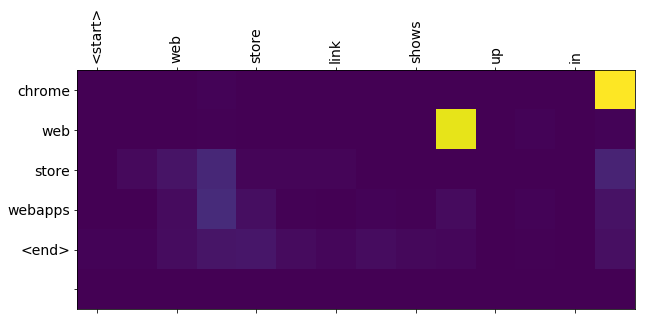

In [52]:
translate(u'web store link shows up in chrome, webapps likely coming soon')

Input: <start> run google chrome in ubuntu with wine <end>
Predicted translation: google chrome ubuntu wine <end> 


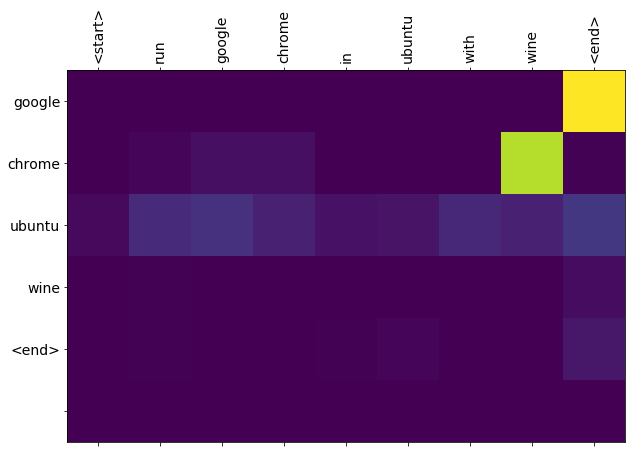

In [49]:
translate(u'run google chrome in ubuntu with wine')

Input: <start> master multiple firefox profiles for more productive browsing <end>
Predicted translation: firefox profiles <end> 


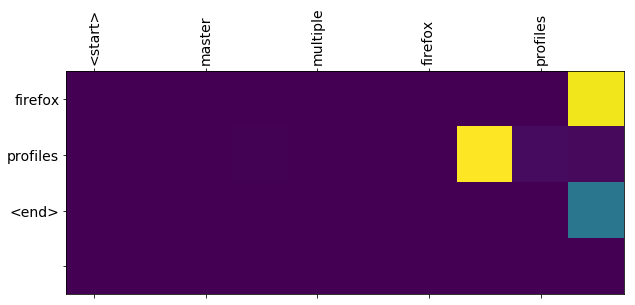

In [50]:
translate('master multiple firefox profiles for more productive browsing')

Input: <start> five best sites for finding deals online <end>
Predicted translation: deals <end> 


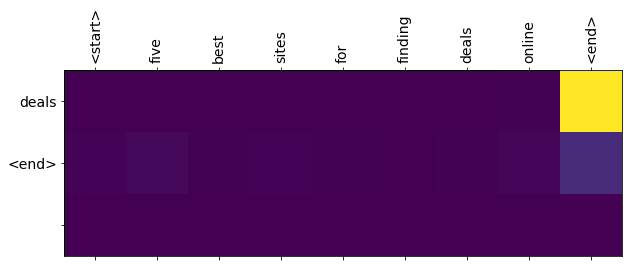

In [35]:
translate(u'five best sites for finding deals online')

Input: <start> make your own firefox site search plug in <end>
Predicted translation: firefox search <end> 


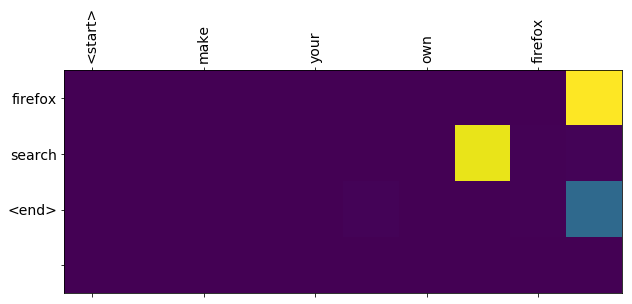

In [37]:
# wrong translation
translate(u'make your own firefox site search plug-in')

In [44]:
  from tensorflow.python.util import compat
  #where to save to?
  export_path_base = 'model'
  export_path = os.path.join(
      compat.as_bytes(export_path_base))
  print ('Exporting trained model to', export_path)

Exporting trained model to b'model'


In [48]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
  
  #This creates a SERVABLE from our model
  #saves a "snapshot" of the trained model to reliable storage 
  #so that it can be loaded later for inference.
  #can save as many version as necessary
  
  #the tensoroflow serving main file tensorflow_model_server
  #will create a SOURCE out of it, the source
  #can house state that is shared across multiple servables 
  #or versions
  
  #we can later create a LOADER from it using tf.saved_model.loader.load
  
  #then the MANAGER decides how to handle its lifecycle
  
builder = saved_model_builder.SavedModelBuilder(export_path)

  # Build the signature_def_map.
  #Signature specifies what type of model is being exported, 
  #and the input/output tensors to bind to when running inference.
  #think of them as annotiations on the graph for serving
  #we can use them a number of ways
  #grabbing whatever inputs/outputs/models we want either on server
  #or via client
classification_inputs = utils.build_tensor_info(serialized_tf_example)
classification_outputs_classes = utils.build_tensor_info(prediction_classes)
classification_outputs_scores = utils.build_tensor_info(values)

   
classification_signature = signature_def_utils.build_signature_def(
    inputs={signature_constants.CLASSIFY_INPUTS: classification_inputs},
    outputs={
        signature_constants.CLASSIFY_OUTPUT_CLASSES:
            classification_outputs_classes,
        signature_constants.CLASSIFY_OUTPUT_SCORES:
            classification_outputs_scores
    },
    method_name=signature_constants.CLASSIFY_METHOD_NAME)

tensor_info_x = utils.build_tensor_info(x)
tensor_info_y = utils.build_tensor_info(y)

prediction_signature = signature_def_utils.build_signature_def(
    inputs={'images': tensor_info_x},
    outputs={'scores': tensor_info_y},
    method_name=signature_constants.PREDICT_METHOD_NAME)
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
  
  #add the sigs to the servable
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={
        'predict_images':
            prediction_signature,
        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            classification_signature,
    },
    legacy_init_op=legacy_init_op)
 #save it!
builder.save()

print ('Done exporting!')

NameError: ignored